# Задание 4
1. Датасет русскоязычных отзывов на аниме. 3 класса: нейтральный, положительный и отрицательный. Требуется качественная обработка данных + **feature engineering**
2. Сравнить случайный лес и бустинг для сентимент анализа
3. Отобразить ключевые слова для решения классификаторов
4. Отрисовать рисунки обученных деревьев из случайного леса и бустинга с указанием текста влияющего на ветвление дерева
5. Использовать SHAP для интерпретации
6. Провести тематическое моделирование отдельно для 3 классов и сравнить с пунктами 3-5
7. Выложить на github

In [ ]:
%pip install pandas nltk seaborn matplotlib emoji num2words lightgbm xgboost
%pip install -U sentence-transformers
%pip install wordcloud

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

## Анализ


In [2]:
!gdown 1HCqWYPrBtBw0fxzvraKhMMTDu_cdIs1m
!gdown 1OwJUdRTvG5wxxJyExYnVGnCWMTZaCK_s
!gdown 19bGOteAuoRbjeEKloCvXnPeBqzFqAB9l
!gdown 1Aq5mUXyywpMfWwwXl9Okx_yRHWI1iSpW

Downloading...
From: https://drive.google.com/uc?id=1HCqWYPrBtBw0fxzvraKhMMTDu_cdIs1m
To: /home/lockr/projects/GBK_internship/assignment_4/dataset1.xlsx
100%|██████████████████████████████████████| 16.1M/16.1M [00:00<00:00, 37.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OwJUdRTvG5wxxJyExYnVGnCWMTZaCK_s
To: /home/lockr/projects/GBK_internship/assignment_4/dataset2.xlsx
100%|██████████████████████████████████████| 13.9M/13.9M [00:00<00:00, 29.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=19bGOteAuoRbjeEKloCvXnPeBqzFqAB9l
To: /home/lockr/projects/GBK_internship/assignment_4/dataset3.xlsx
100%|██████████████████████████████████████| 24.3M/24.3M [00:00<00:00, 37.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Aq5mUXyywpMfWwwXl9Okx_yRHWI1iSpW
To: /home/lockr/projects/GBK_internship/assignment_4/dataset4.xlsx
100%|██████████████████████████████████████| 20.3M/20.3M [00:00<00:00, 35.4MB/s]


In [3]:
df = pd.concat([pd.read_excel('dataset1.xlsx'), pd.read_excel('dataset2.xlsx'), pd.read_excel('dataset3.xlsx'), pd.read_excel('dataset4.xlsx')])

df.drop_duplicates(subset='Text', inplace=True)
df.dropna(inplace=True)

df.describe()

,Anime,Rate,Text
count,73165,73165,73165
unique,8663,3,73165
top,Милый во Франксе / Darling in the FranXX,Положительный,"после первой арки несколько разочаровался, ожи..."
freq,409,30045,1


,Rate,% of Count
Rate,,
Положительный,30045,41.064717
Нейтральный,25243,34.501469
Отрицательный,17877,24.433814


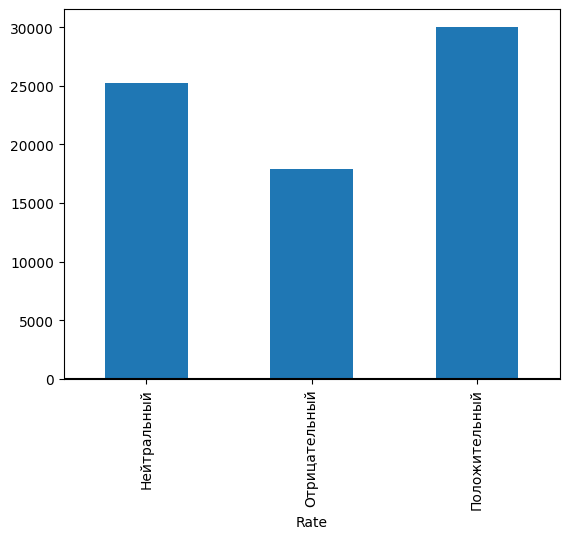

In [4]:
def count_table(df, c):
        count = df[c].value_counts()
        count_percent = 100 * count / len(df)
        count_table = pd.concat([count, count_percent], axis=1)

        count_table.columns = [c, '% of Count']
        count_table.round(2)

        gb = df.groupby(df[c])
        targetEDA=gb[c].aggregate(len)

        plt.figure()
        targetEDA.plot(kind='bar', grid=False)
        plt.axhline(0, color='k')

        return count_table

count_table(df, 'Rate')

## Очистка

In [30]:
from pymystem3 import Mystem
import string



terms = {
    "amv": "музыкальные видеоклипы из аниме",
    "арка": "часть серий с общей сюжетной линией",
    "архетип": "набор качеств персонажа как цундере",
    "ваншот": "небольшая манга из одной главы",
    "слайс": "поджанр повседневной жизни",
    "гаремник": "аниме где вокруг гг много девушек",
    "гуро": "жестокие формы насилия в хентае",
    "гяру": "японское молодежное движение с ярким стилем",
    "датабук": "книга с информацией об аниме или манге",
    "дзёсэй": "жанр для молодых женщин",
    "додзинси": "любительская манга изданная самостоятельно",
    "дэсу": "форма глагола-связки вежливости",
    "дроп": "бросить смотреть или читать произведение",
    "ёнкома": "формат манги из четырёх кадров",
    "исекай": "жанр с переносом гг в другой мир",
    "кодомо": "метажанр для детей до 12 лет",
    "кудэрэ": "молчаливые апатичные персонажи",
    "лайв-экшен": "фильм или дорама по манге",
    "лайт-новелла": "японский роман с иллюстрациями",
    "мангака": "автор манги",
    "махо-сёдзё": "аниме о девочках-волшебницах",
    "метажанр": "жанр по возрасту и гендеру",
    "меха": "жанр о битвах роботов",
    "моэ-персонажи": "умилительные персонажи",
    "нэко": "кошка или девушка похожая на неё",
    "ova": "аниме распространяемое на дисках",
    "ona": "аниме для интернета",
    "онгоинг": "аниме которое сейчас выходит",
    "онии-тян и онээ-тян": "обращение к старшему брату или сестре",
    "опенинг": "музыкальная композиция в начале серии",
    "отомэ-игра": "игра для девушек с романтическим сюжетом",
    "панцушот": "показ женских трусов",
    "рав": "необработанная серия аниме или манги",
    "сёдзё": "метажанр для девушек от 12 до 18 лет",
    "сёнэн": "метажанр для мальчиков от 12 до 18 лет",
    "сёнэн-ай": "жанр о романтических отношениях между юношами",
    "сёдзё-ай": "жанр о романтических отношениях между девушками",
    "сётакон": "жанр хентая с мальчиками",
    "сканлейт": "любительский перевод манги",
    "сэйнэн": "метажанр для молодых мужчин от 18 до 25 лет",
    "сэйю": "японские актёры озвучки",
    "сэмпай": "человек более опытный в какой-то сфере",
    "спокон": "жанр о спорте и достижениях",
    "тентакли": "щупальцы в хентае",
    "тайтл": "произведение например аниме или ova",
    "фансервис": "метажанр для привлечения аудитории",
    "фандаб": "любительский перевод аниме с озвучкой",
    "фансаб": "любительский перевод аниме с субтитрами",
    "филлер": "серия не развивающая сюжет",
    "химэдэрэ": "надменные и эгоистичные персонажи",
    "цундэрэ": "персонажи с переменчивым поведением",
    "эндинг": "музыкальная композиция в конце серии",
    "этти": "жанр с эротическими сценами",
    "юри": "жанр о лесбийских отношениях",
    "яой": "жанр о гомосексуальных отношениях",
    "яндэрэ": "любящий персонаж ставший одержимым",
    "абьюзер": "человек использующий манипуляции и насилие",
    "агриться": "проявлять агрессию злиться",
    "ауф": "выражение восхищения",
    "байтить": "воровать идеи",
    "банить": "ограничивать доступ",
    "баттхерт": "сильная негативная эмоция",
    "биполярочка": "крайне непоследовательное поведение",
    "буллинг": "массовое притеснение",
    "бумер": "представитель старшего поколения",
    "быть в моменте": "осознавать происходящее",
    "быть в потоке": "чувствовать себя увлечённым",
    "быть в ресурсе": "чувствовать себя полным сил",
    "вайб": "атмосфера",
    "вписка": "квартира для вечеринки",
    "втф": "сокращение от what the fuck",
    "го": "пойдём",
    "движ": "активные действия",
    "дисс": "оскорбляющая рэп-композиция",
    "думер": "юный пессимист",
    "жиза": "жизненная ситуация",
    "зашквар": "позор",
    "зумер": "представитель цифрового поколения",
    "изи": "легко",
    "кавай": "очень милое",
    "камон": "призыв к действию",
    "катка": "игровой матч",
    "кек": "смех",
    "краш": "предмет обожания",
    "кринж": "испанский стыд",
    "криповый": "страшный",
    "куколд": "рогоносец",
    "ламповый": "умилительный",
    "лд": "лучший друг",
    "лойс": "лайк",
    "лол": "громко смеюсь",
    "лп": "лучшая подруга",
    "мерч": "товары с символикой",
    "миллениалы": "поколение детей 1980-90-х годов",
    "нуб": "новичок",
    "нюдесы": "фотографии обнаженной натуры",
    "омг": "боже мой",
    "падра": "подруга",
    "паль": "подделка",
    "пранк": "розыгрыш",
    "пруфы": "доказательства",
    "рипнуться": "умереть",
    "рофлить": "смеяться",
    "слэмиться": "толкотня на концертах",
    "сасный": "привлекательный",
    "скипнуть": "пропустить",
    "стримить": "вести трансляцию",
    "стэнить": "восхищаться",
    "токсик": "человек без эмпатии",
    "триповать": "изменённое сознание",
    "фейспалм": "жест разочарования",
    "флексить": "танцевать хвастаться",
    "хайп": "ажиотаж",
    "хейтить": "критиковать",
    "чекать": "проверять",
    "челендж": "соревнование",
    "чилить": "расслабляться",
    "читер": "мошенник в играх",
    "чсв": "завышенная самооценка",
    "шеймить": "стыдить",
    "шерить": "делиться",
    "шмот": "одежда",
    "юзлес": "бесполезный"
}
m = Mystem()
anime_names_sw = []
df['Anime'].apply(lambda text: anime_names_sw.extend( \
    m.lemmatize(text.translate(str.maketrans(string.punctuation+string.digits, ' '* len(string.punctuation+string.digits)))) \
        ))

anime_names_sw = set(filter(lambda x: len(x)>1 and not(x.isspace()), anime_names_sw))
freq_words = ['это', 'главный', 'герой', 'серия', 'эпизод', 'сериал', 'аниме', 'композиция', 'спойлер', 'знать',\
               'сюжетный', 'сюжет', 'либо', 'сделать', 'время', 'линия', 'история', 'сезон', 'видимо', 'вид',\
                  'момент', 'поэтому', 'однако', 'место', 'автор', 'игра', 'общий', 'начало', 'игра', 'хотя', \
                    'каждый', 'показывать', 'немного', 'именно']

In [31]:
import emoji
from tqdm import tqdm
from pymystem3 import Mystem
import string
from num2words import num2words
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
tqdm.pandas()
def _conv_num(match):
    return num2words(match.group(), lang='ru')

def standartize_text(column):
    m = Mystem()
    sw = list(stopwords.words("russian") + stopwords.words("english"))
    sw.remove('не')
    sw.append(anime_names_sw)
    sw.append(freq_words)
    new_terms = {term:" ".join([x for x in m.lemmatize(terms[term]) if x not in sw])  for term in terms.keys()}
    slang_words = new_terms.keys()
    column = column.progress_apply(lambda text: re.sub(r'\b\d{1,10}\b', _conv_num,text))
    column = column.progress_apply(lambda text: emoji.demojize(text, language="ru"))
    column = column.replace(to_replace=r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''' ,\
                    value=' ', regex=True)
    column = column.replace(to_replace=r'\b[^\W\dА-Яа-яёЁA-Za-z]+\b', value=' ', regex=True)
    column = column.replace(to_replace=r"(.)\1\1+", value=r'\1\1', regex=True)
    column = column.str.translate(str.maketrans(string.punctuation+string.digits, ' '* len(string.punctuation+string.digits)))
    column = column.replace(to_replace=r'\s+', value=' ', regex=True).str.strip()
    column = column.progress_apply(lambda text: " ".join([word if word not in slang_words else new_terms[word] \
                                                  for word in m.lemmatize(text) if word not in sw]))

    return column


df['clean'] = df['Text'].copy()

df['clean'] = standartize_text(df['clean'])
df

[nltk_data] Downloading package stopwords to /home/lockr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 73165/73165 [10:11<00:00, 119.68it/s]


,Anime,Rate,Text,clean
0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи...",первый часть серия общий сюжетный ...
1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над...",концовка мутный ничто не понимать ...
2,Мобильный воин Гандам: Единорог / Kidou Senshi...,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х...",сказать никакой сравнень Seed ...
3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...,досматривать переполнять эмоция ...
4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ...",правда не отрываться медуза ...
...,...,...,...,...
15423,Пожиратель звёзд / Tunshi Xingkong,Положительный,Я просмотрел 82 серии Пожирателя звёзд (Swallo...,просматривать восемьдесят серия пожи...
15424,Пожиратель звёзд 2 / Tunshi Xingkong 2nd Season,Положительный,Я был сильно заинтригован аниме Поглощающая Зв...,сильно заинтриговывать аниме поглоща...
15425,Повелитель 2 / Overlord II,Нейтральный,докатились. после просмотра этого чуда я добав...,докатиться просмотр это чудо добав...
15426,Ангел по соседству / Otonari no Tenshi-sama ni...,Положительный,Вокруг этого произведения собралось достаточно...,вокруг произведение собираться достато...


In [32]:
df.head()

,Anime,Rate,Text,clean
0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи...",первый часть серия общий сюжетный ...
1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над...",концовка мутный ничто не понимать ...
2,Мобильный воин Гандам: Единорог / Kidou Senshi...,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х...",сказать никакой сравнень Seed ...
3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...,досматривать переполнять эмоция ...
4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ...",правда не отрываться медуза ...


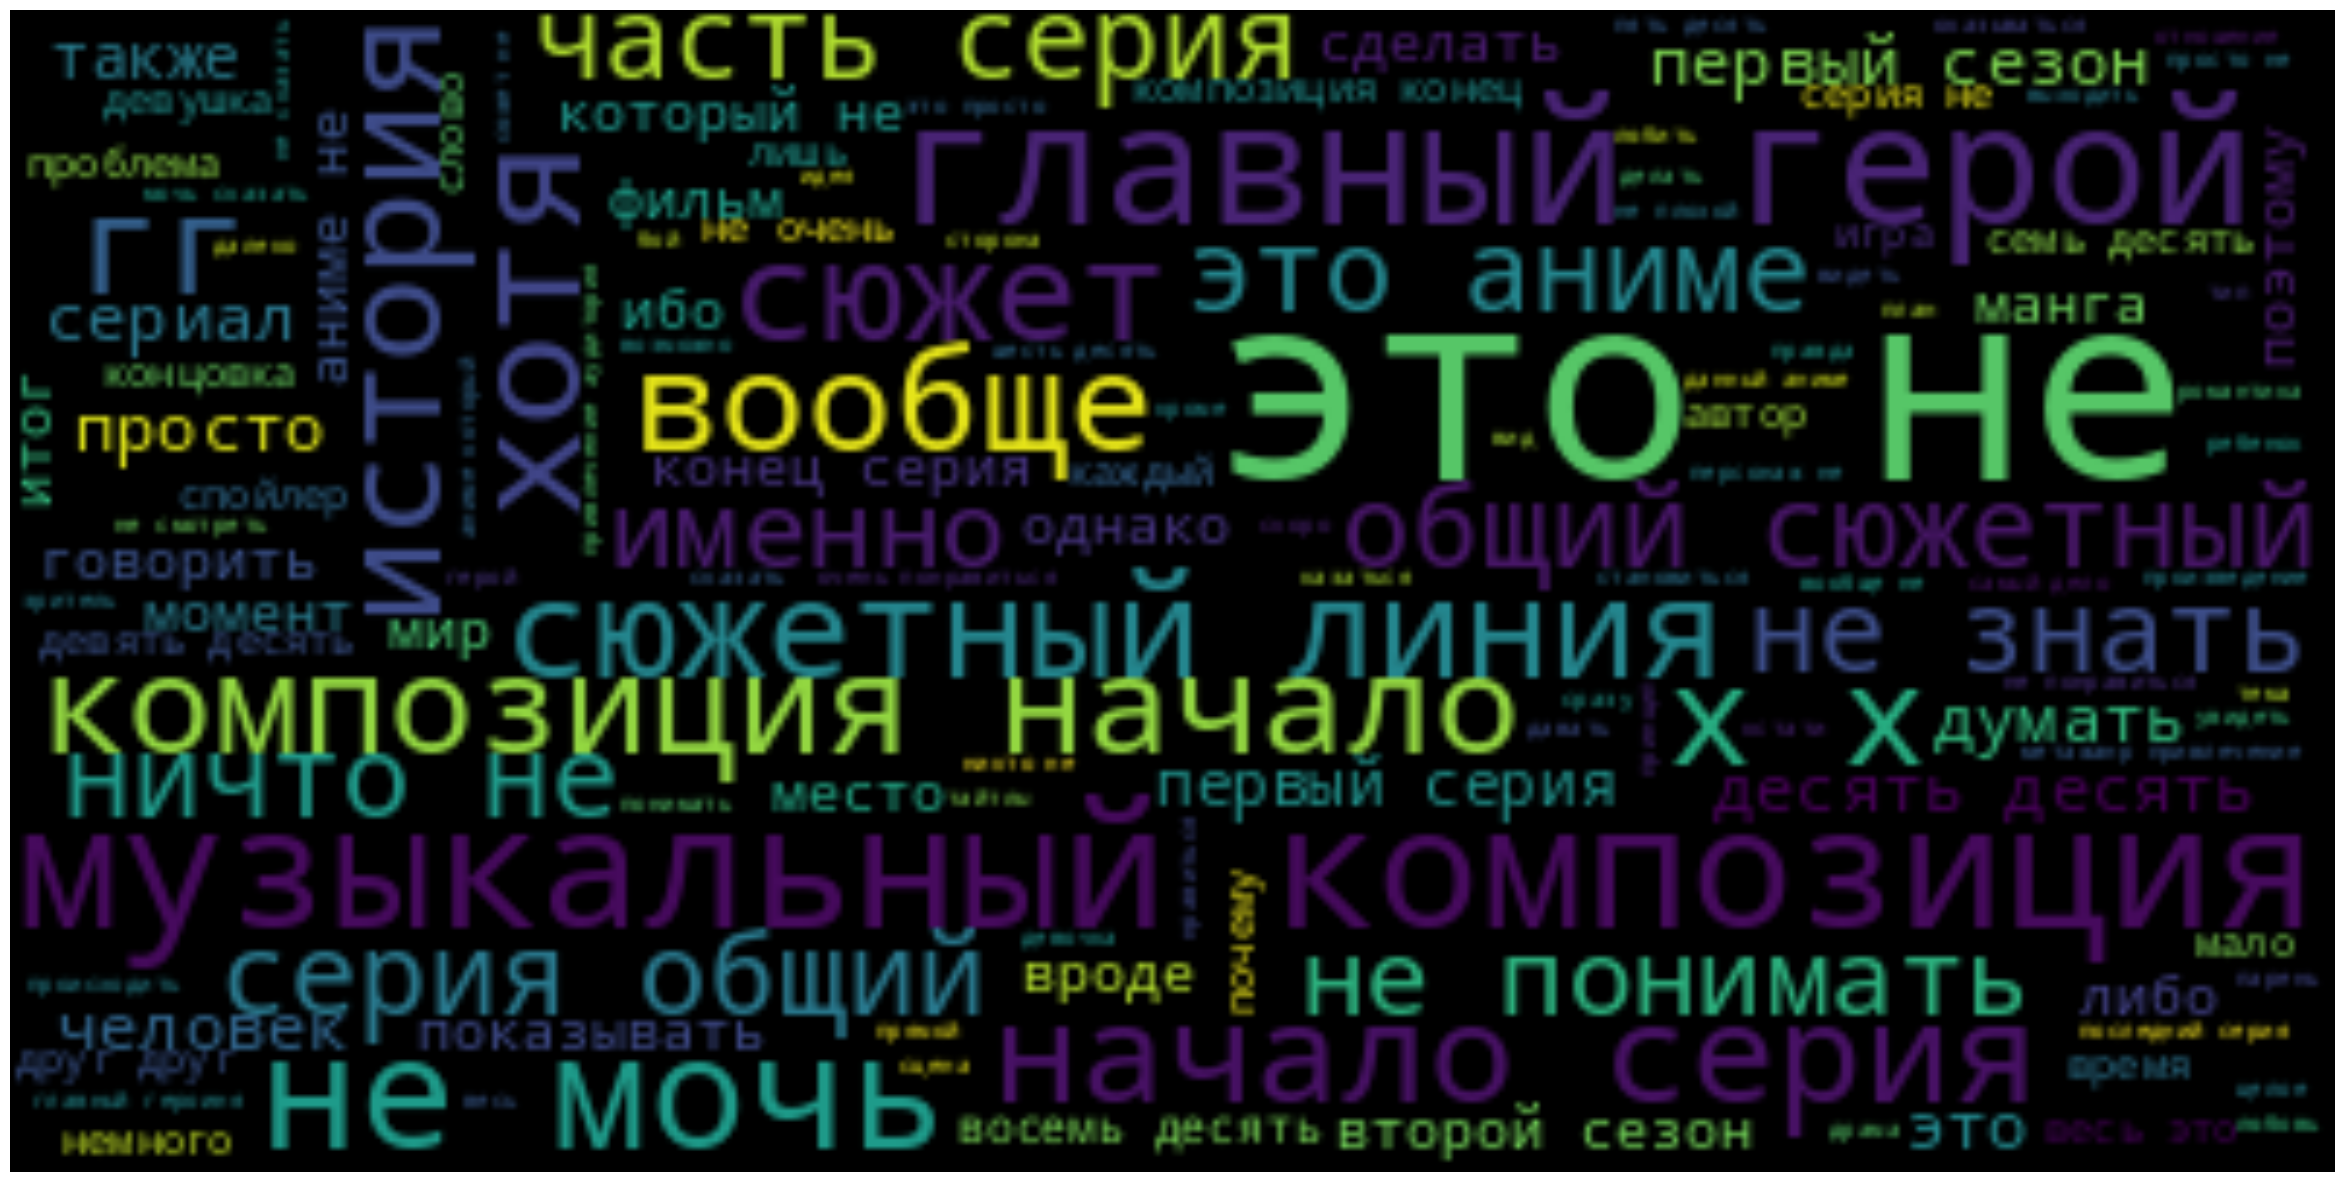

In [33]:
from wordcloud import WordCloud


wc = WordCloud().generate(" ".join(df['clean']))

plt.figure(figsize=(30, 20))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [34]:
df.to_excel('cleaned.xlsx')

## Обучение

### Эмбеддинги

In [6]:
!gdown 1--uXaw9Ueg4risxmDUoMIr4vpCHDmQI5

Downloading...
From (original): https://drive.google.com/uc?id=1--uXaw9Ueg4risxmDUoMIr4vpCHDmQI5
From (redirected): https://drive.google.com/uc?id=1--uXaw9Ueg4risxmDUoMIr4vpCHDmQI5&confirm=t&uuid=36dccab8-1f76-417a-aee5-29b1883f8bf5
To: /home/lockr/projects/GBK_internship/assignment_4/cleaned.xlsx
100%|████████████████████████████████████████| 129M/129M [00:01<00:00, 85.2MB/s]


In [3]:
df = pd.read_excel("cleaned.xlsx")

In [ ]:
from sentence_transformers import SentenceTransformer
from tqdm.autonotebook import tqdm, trange

model = SentenceTransformer("seara/rubert-tiny2-russian-sentiment", device=0)

In [ ]:
embeddings = model.encode(df['clean'].to_list(), show_progress_bar=True)

embeddings.shape

Batches:   0%|          | 0/2287 [00:00<?, ?it/s]

(73165, 312)

In [ ]:
from sentence_transformers import SentenceTransformer
from tqdm.autonotebook import tqdm, trange

model = SentenceTransformer("sergeyzh/rubert-tiny-turbo", device=0)

In [ ]:
embeddings = model.encode(df['clean'].to_list(), show_progress_bar=True)

embeddings.shape

Batches:   0%|          | 0/2287 [00:00<?, ?it/s]

(73165, 312)

In [ ]:
pd.DataFrame(embeddings).to_excel("embeddings.xlsx")

### Обучение моделей бустинга

In [7]:
!gdown 1-0BPRbaEIGoxwM61nSc85bB8OALvOLp-

Downloading...
From (original): https://drive.google.com/uc?id=1--xboJAEOmhqhnzAVIpZjvdrzRZoOZ0J
From (redirected): https://drive.google.com/uc?id=1--xboJAEOmhqhnzAVIpZjvdrzRZoOZ0J&confirm=t&uuid=e3637e33-46db-4b87-9424-f57ca233fa15
To: /home/lockr/projects/GBK_internship/assignment_4/embeddings.xlsx
100%|████████████████████████████████████████| 297M/297M [00:36<00:00, 8.25MB/s]


In [2]:
embeddings = pd.read_excel('embeddings.xlsx')
embeddings = np.array(embeddings)

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold,  train_test_split
from sklearn.ensemble import RandomForestClassifier


In [4]:
df = pd.read_excel("cleaned.xlsx")

le = LabelEncoder()
df["class"] = le.fit_transform(df["Rate"])
df.drop(columns=["Rate"], inplace=True)
labels = le.classes_

In [5]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

def run_pipeline(pipeline, train_feats, train_lbls, test_feats, test_lbls, labels):
    pipeline.fit(train_feats, train_lbls)
    predictions = pipeline.predict(test_feats)
    pred_proba = pipeline.predict_proba(test_feats)
    print('roc_auc: ', roc_auc_score(test_lbls, pred_proba, multi_class="ovr"))
    print('accuracy: ', accuracy_score(test_lbls, predictions))
    print('confusion matrices: ')
    cm = confusion_matrix(test_lbls, predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_display.plot()
    plt.show()
    print('classification_report: ')
    print(classification_report(test_lbls, predictions, target_names=labels))
    # plot_roc_curve(test_feats, pred_proba)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer

# Создание TF-IDF матрицы
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean']).toarray()


X_combined = np.hstack((X_tfidf, embeddings))

scaler = StandardScaler()
X_combined = scaler.fit_transform(X_combined)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['class'], stratify=df['class'], test_size=0.3, random_state=42)

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

#### RandomForest

roc_auc:  0.7194517010135161
accuracy:  0.5353986332574032
confusion matrices: 


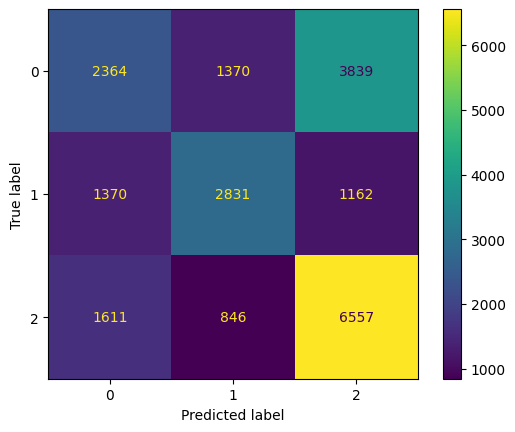

classification_report: 
               precision    recall  f1-score   support

  Нейтральный       0.44      0.31      0.37      7573
Отрицательный       0.56      0.53      0.54      5363
Положительный       0.57      0.73      0.64      9014

     accuracy                           0.54     21950
    macro avg       0.52      0.52      0.52     21950
 weighted avg       0.52      0.54      0.52     21950



In [17]:
run_pipeline(RandomForestClassifier(n_estimators=700,class_weight=dict(enumerate(classes_weights)), verbose=0, n_jobs=-1), X_train, y_train, X_test, y_test, labels)

#### LGBM

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing 

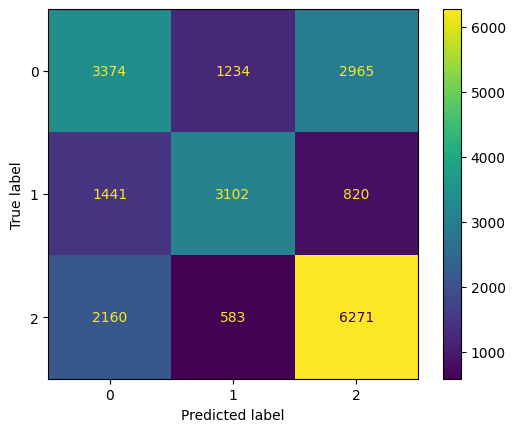

classification_report: 
               precision    recall  f1-score   support

  Нейтральный       0.48      0.45      0.46      7573
Отрицательный       0.63      0.58      0.60      5363
Положительный       0.62      0.70      0.66      9014

     accuracy                           0.58     21950
    macro avg       0.58      0.57      0.57     21950
 weighted avg       0.58      0.58      0.58     21950



In [26]:
from lightgbm import LGBMClassifier

params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'boosting': 'gbdt',
    'is_unbalance': True,
    'num_leaves': 150,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.15,
    'verbose': 0
}
clf = LGBMClassifier(**params)
run_pipeline(clf, X_train, y_train, X_test, y_test, labels)

#### XGBoost

roc_auc:  0.7769822035866838
accuracy:  0.5999088838268792
confusion matrices: 


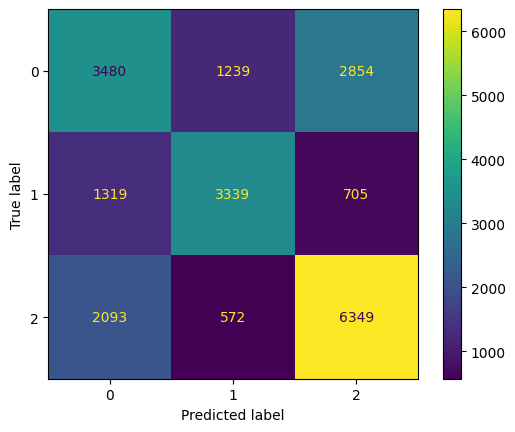

classification_report: 
               precision    recall  f1-score   support

  Нейтральный       0.50      0.46      0.48      7573
Отрицательный       0.65      0.62      0.64      5363
Положительный       0.64      0.70      0.67      9014

     accuracy                           0.60     21950
    macro avg       0.60      0.60      0.60     21950
 weighted avg       0.60      0.60      0.60     21950



In [21]:
import xgboost as xgb

# Настройка модели XGBoost
xgb_model = xgb.XGBClassifier(verbose=3, objective='multi:softmax', sample_weight=classes_weights,\
                              n_estimators=500, learning_rate=0.15, max_depth=5, n_jobs=-1)

run_pipeline(xgb_model, X_train, y_train, X_test, y_test, labels)

In [ ]:
# Настройка модели XGBoost
xgb_model = xgb.XGBClassifier(verbose=3, objective='multi:softmax', sample_weight=classes_weights,\
                              n_estimators=500, learning_rate=0.15, max_depth=5, n_jobs=-1)
